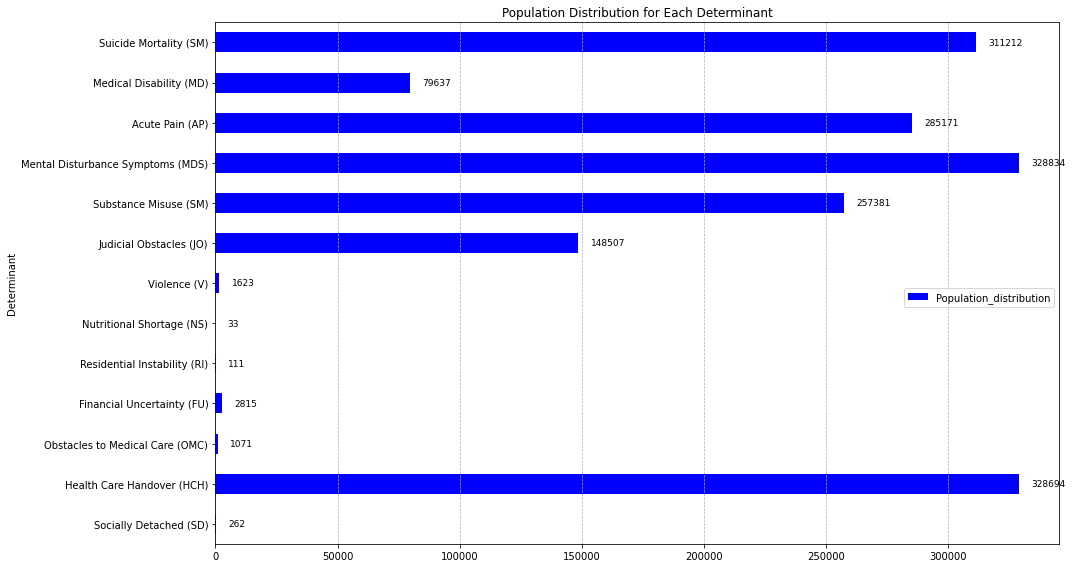

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'cleaned_predictions_2ndjune.csv'
data = pd.read_csv(file_path)

# List of new determinant names
determinant_names = [
    'Socially Detached (SD)', 'Health Care Handover (HCH)', 'Obstacles to Medical Care (OMC)', 
    'Financial Uncertainty (FU)', 'Residential Instability (RI)', 'Nutritional Shortage (NS)', 
    'Violence (V)', 'Judicial Obstacles (JO)', 'Substance Misuse (SM)', 
    'Mental Disturbance Symptoms (MDS)', 'Acute Pain (AP)', 'Medical Disability (MD)', 
    'Suicide Mortality (SM)'
]

# List of columns to check for binary values, excluding 'opioid_pr_ab'
binary_columns = [
    'determinant_1', 'determinant_2', 'determinant_3', 'determinant_4',
    'determinant_5', 'determinant_6', 'determinant_7', 'determinant_8', 'determinant_9',
    'determinant_10', 'determinant_11', 'determinant_12', 'determinant_13'
]

# Drop the 'opioid_pr_ab' column
data = data.drop(columns=['opioid_pr_ab'])

# Convert 'TRUE'/'FALSE' to 1/0 if necessary
data[binary_columns] = data[binary_columns].applymap(lambda x: 1 if x == 'TRUE' else (0 if x == 'FALSE' else x))

# Function to count the number of 1s
def count_true_values(column):
    return data[column].sum()

# Create a list to store counts
true_counts = [count_true_values(col) for col in binary_columns]

# Create a DataFrame for plotting
counts_df = pd.DataFrame({
    'Determinant': determinant_names,
    'Population_distribution': true_counts
})

# Plot the population distribution for each determinant as a horizontal bar chart
ax = counts_df.set_index('Determinant').plot(kind='barh', figsize=(15, 8), color='blue')
plt.title('Population Distribution for Each Determinant')
#plt.xlabel('Number of True Values')
#plt.ylabel('Determinants')
plt.xlim(left=0)  # Ensure the x-axis starts from zero
plt.grid(axis='x', linestyle='--', linewidth=0.7)

# Add annotations to the bars with an offset
offset = 5000
for index, value in enumerate(counts_df['Population_distribution']):
    ax.text(value + offset, index, f'{value}', va='center', color='black', fontsize=9)

# Move the legend to the side
plt.legend(['Population_distribution'], bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()


In [1]:
import os
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel

# Set the device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Disable tokenizers parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load the tokenizer and model for BioClinicalBERT
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)

# Load the large CSV file in chunks to handle memory efficiently
file_path = 'cleaned_predictions_2ndjune.csv'
chunk_size = 10000  # Define an appropriate chunk size
df_chunks = pd.read_csv(file_path, chunksize=chunk_size)

# Function to generate embeddings
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length').to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

# Process each chunk to generate embeddings
def process_chunk(chunk):
    chunk['embeddings'] = chunk['text'].apply(lambda x: get_embeddings(x).squeeze())
    return chunk

# Initialize an empty list to store processed chunks
processed_chunks = []

# Process each chunk
for chunk in df_chunks:
    processed_chunk = process_chunk(chunk)
    processed_chunks.append(processed_chunk)

# Concatenate all processed chunks
df = pd.concat(processed_chunks)

# Flatten the embeddings and add to the dataframe
flattened_embeddings = np.array([embedding.flatten() for embedding in df['embeddings']])
flattened_embeddings_df = pd.DataFrame(flattened_embeddings, index=df.index)
df = df.drop(columns=['embeddings'])
df = pd.concat([df.reset_index(drop=True), flattened_embeddings_df.reset_index(drop=True)], axis=1)

# Save the dataframe with embeddings to a new CSV file
df.to_csv('predictions_with_embeddings_sampled.csv', index=False)


/home/mpagare/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


In [2]:
#!pip install keras


In [3]:
#!pip install tensorflow


In [4]:
from keras.layers import Input, Dense, Dropout, Concatenate
from keras.models import Model
from keras.optimizers import Adam

# Define the outcome and confounders
outcome = 'opioid_pr_ab'
embedding_columns = flattened_embeddings_df.columns.tolist()
confounders = embedding_columns

# Ensure that the outcome column is numeric
df[outcome] = pd.to_numeric(df[outcome], errors='coerce')

# Create Siamese Neural Network model
def create_siamese_nn(input_dim, hidden_dim, dropout_prob):
    x = Input(shape=(input_dim,), name='x')
    shared = Dense(hidden_dim, activation='relu')(x)
    shared = Dropout(dropout_prob)(shared)
    t1 = Input(shape=(1,), name='t1')
    t1_shared = Dense(hidden_dim, activation='relu')(t1)
    t1_shared = Dropout(dropout_prob)(t1_shared)
    t1_output = Dense(1, activation='linear')(Concatenate()([shared, t1_shared]))
    t0 = Input(shape=(1,), name='t0')
    t0_shared = Dense(hidden_dim, activation='relu')(t0)
    t0_shared = Dropout(dropout_prob)(t0_shared)
    t0_output = Dense(1, activation='linear')(Concatenate()([shared, t0_shared]))
    model = Model(inputs=[x, t0, t1], outputs=[t0_output, t1_output])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Subgroup identification using Siamese Neural Network
def subgroup_identification(data, treatment_col, outcome_col, features, hidden_dim, dropout_prob, epochs, k):
    t0_data = data[data[treatment_col] == 0].copy()
    t1_data = data[data[treatment_col] == 1].copy()
    mx_dim = min(t0_data.shape[0], t1_data.shape[0])
    t0_data = t0_data.head(mx_dim)
    t1_data = t1_data.head(mx_dim)
    siamese_nn = create_siamese_nn(len(features), hidden_dim, dropout_prob)
    siamese_nn.fit([t0_data[features], t0_data[treatment_col], t1_data[treatment_col]], [t0_data[outcome_col], t1_data[outcome_col]], epochs=epochs, verbose=0)
    t0_effects, t1_effects = siamese_nn.predict([data[features], data[treatment_col], data[treatment_col]])
    abs_effects = abs(t1_effects - t0_effects)
    subgroup = data[abs_effects > k]
    return subgroup

# Identify the subgroup using the Siamese Neural Network
features = embedding_columns
hidden_dim = 200
dropout_prob = 0.5
epochs = 100
k = 0.72
subgroup = subgroup_identification(df, 'opioid_pr_ab', 'opioid_pr_ab', features, hidden_dim, dropout_prob, epochs, k)

# Subsample 10,000 data points from the identified subgroup
subsampled_df = subgroup.sample(n=10000, random_state=42) if len(subgroup) > 10000 else subgroup


10369/10369 [==============================] - 21s 2ms/step


In [ ]:
subgroup.shape

Length of the subsampled DataFrame: 10000
Columns in the subsampled DataFrame:
Index([            'text',     'opioid_pr_ab',    'determinant_1',
          'determinant_2',    'determinant_3',    'determinant_4',
          'determinant_5',    'determinant_6',    'determinant_7',
          'determinant_8',
       ...
                      759,                760,                761,
                      762,                763,                764,
                      765,                766,                767,
       'propensity_score'],
      dtype='object', length=784)


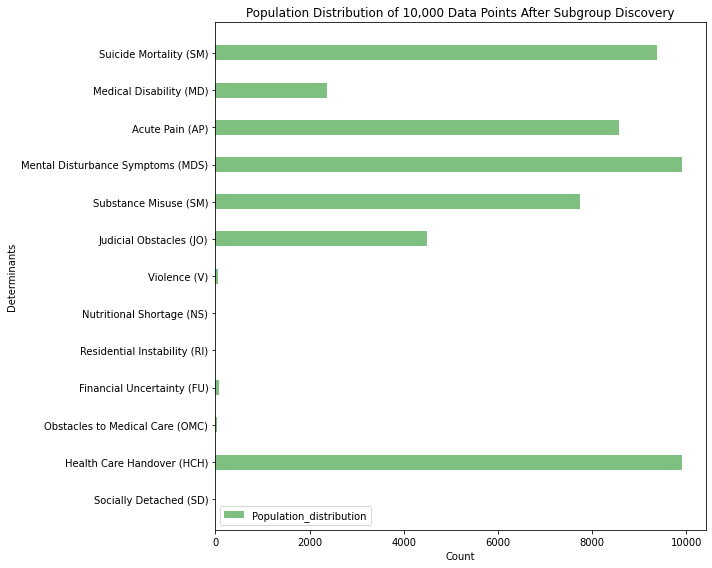

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that 'subsampled_df' is the 10,000 subsampled data points after subgroup discovery
print(f"Length of the subsampled DataFrame: {len(subsampled_df)}")

# List of determinant names
determinant_names = [
    'Socially Detached (SD)', 'Health Care Handover (HCH)', 'Obstacles to Medical Care (OMC)', 
    'Financial Uncertainty (FU)', 'Residential Instability (RI)', 'Nutritional Shortage (NS)', 
    'Violence (V)', 'Judicial Obstacles (JO)', 'Substance Misuse (SM)', 
    'Mental Disturbance Symptoms (MDS)', 'Acute Pain (AP)', 'Medical Disability (MD)', 
    'Suicide Mortality (SM)'
]

# List of columns to check for binary values
binary_columns = [
    'determinant_1', 'determinant_2', 'determinant_3', 'determinant_4',
    'determinant_5', 'determinant_6', 'determinant_7', 'determinant_8', 'determinant_9',
    'determinant_10', 'determinant_11', 'determinant_12', 'determinant_13'
]

# Verify that the binary columns are in the subsampled DataFrame
print("Columns in the subsampled DataFrame:")
print(subsampled_df.columns)

# Create a list to store counts for each binary determinant
counts_list = []

# Collect counts for each column
for col, name in zip(binary_columns, determinant_names):
    true_count = subsampled_df[col].sum()
    counts_list.append({'Determinant': name, 'Population_distribution': true_count})

# Convert the list to a DataFrame
counts_df = pd.DataFrame(counts_list)

# Plot the population distribution as a horizontal bar chart with thinner bars
plt.figure(figsize=(10, 8))
bar_height = 0.4  # Adjust this value for thinner bars
plt.barh(counts_df['Determinant'], counts_df['Population_distribution'], color='green', alpha=0.5, height=bar_height, label='Population_distribution')
plt.xlabel('Count')
plt.ylabel('Determinants')
plt.title('Population Distribution of 10,000 Data Points After Subgroup Discovery')
plt.legend()
plt.tight_layout()
plt.show()
